In [6]:
from bids import BIDSLayout
import os

# Define your root directory
data_path = '/Volumes/T9/ds001486/derivatives/fmriprep'

# Initialize the layout
layout = BIDSLayout(data_path, validate=False, derivatives=False)

# Get all preprocessed BOLD files for the math task
# This returns a list of objects containing path info
bold_files = layout.get(suffix='bold', 
                        extension='nii.gz', 
                        desc='preproc', 
                        return_type='file')

In [13]:
import numpy as np
import os
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# --- 1. Your Defined Groups ---
mld_subs = ['059', '065', '067', '069', '071', '075', '076', '077', 
            '078', '083', '088', '095', '096', '103', '106']

td_subs = ['090', '036', '013', '008', '057', '070', '023', '024', 
           '053', '044', '034', '060', '007', '027', '010']

# --- 2. Setup Atlas and Masker ---
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True, memory=None)
conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)



[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018


In [18]:
import pandas as pd
import numpy as np
import os

X = []          
y_group = []    
groups = []     

print("🚀 Starting feature extraction (Math only)...")

# Ensure your output folder is set (don't save to the T9 drive!)
output_dir = os.path.expanduser('~/Desktop/math_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for bold_path in bold_files:
    filename = os.path.basename(bold_path)
    
    # 1. Task Filtering
    if any(task in filename for task in ['task-Rhyming', 'task-Num']):
        continue 

    # 2. Confound Path Construction
    parts = filename.split('_')
    essential_parts = [p for p in parts if any(x in p for x in ['sub-', 'ses-', 'task-', 'run-'])]
    confound_name = "_".join(essential_parts) + "_desc-confounds_timeseries.tsv"
    confound_path = os.path.join(os.path.dirname(bold_path), confound_name)

    if not os.path.exists(confound_path):
        continue

    # 3. Subject ID and Grouping
    sub_id = filename.split('_')[0].split('-')[1] 
    group_label = 1 if sub_id in mld_subs else 0
    
    try:
        # --- THE CLEANING SLEDGEHAMMER ---
        # Load confounds
        df = pd.read_csv(confound_path, sep='\t')
        
        # Select only numeric columns (important!)
        df_numeric = df.select_dtypes(include=[np.number])
        
        # Fill NaNs with 0 (Handles the first-row derivative issue)
        # and also drop any columns that are still entirely NaNs
        df_clean = df_numeric.fillna(0).dropna(axis=1, how='all')
        
        # --- EXTRACTION ---
        # Update settings to stop the warnings
        masker.set_params(standardize='zscore_sample')
        conn_measure.set_params(standardize='zscore_sample') 
        
        # Process the data
        time_series = masker.fit_transform(bold_path, confounds=df_clean)
        
        # Check for NaNs in the signal itself
        if np.any(np.isnan(time_series)) or np.any(np.isinf(time_series)):
            print(f"⚠️ {sub_id} has bad signal (NaNs/Infs). Skipping.")
            continue
            
        correlation_vector = conn_measure.fit_transform([time_series])[0]
        
        # --- SUCCESS ---
        X.append(correlation_vector)
        y_group.append(group_label)
        groups.append(sub_id) 
        print(f"✅ {sub_id} added successfully.")
        
    except Exception as e:
        print(f"❌ Error on {sub_id}: {e}")

# --- FINAL SAVE ---
X = np.array(X)
y = np.array(y_group)
groups = np.array(groups)

np.save(os.path.join(output_dir, 'X_features.npy'), X)
np.save(os.path.join(output_dir, 'y_labels.npy'), y)
np.save(os.path.join(output_dir, 'subject_groups.npy'), groups)

print(f"\n🎉 DONE! Saved {len(y)} samples to {output_dir}")

🚀 Starting feature extraction (Math only)...


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 added successfully.
✅ 106 added successfully.

🎉 DONE! Saved 240 samples to /Users/jchong058/Desktop/math_results


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_26400/626613370.py:54: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


Matplotlib is building the font cache; this may take a moment.


📊 Dataset Loaded: 240 runs across 30 subjects.

🎯 Total Accuracy: 59.58%

--- Detailed Report ---
                  precision    recall  f1-score   support

    Typical (TD)       0.60      0.57      0.59       120
Difficulty (MLD)       0.59      0.62      0.60       120

        accuracy                           0.60       240
       macro avg       0.60      0.60      0.60       240
    weighted avg       0.60      0.60      0.60       240



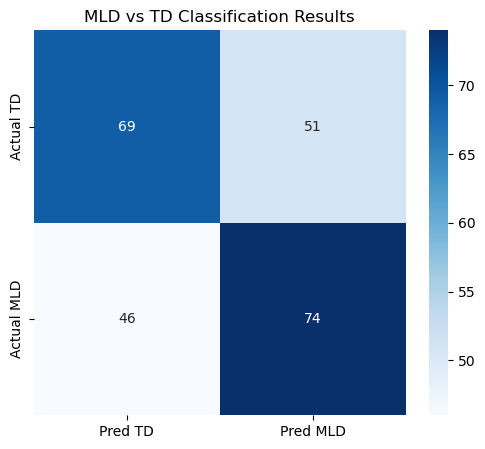

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. Load the data from your Desktop
output_dir = os.path.expanduser('~/Desktop/math_results')
X = np.load(os.path.join(output_dir, 'X_features.npy'))
y = np.load(os.path.join(output_dir, 'y_labels.npy'))
groups = np.load(os.path.join(output_dir, 'subject_groups.npy'))

print(f"📊 Dataset Loaded: {X.shape[0]} runs across {len(np.unique(groups))} subjects.")

# 2. Build the Pipeline
# We scale the data (StandardScaler) so the SVM doesn't get biased by large values
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])

# 3. Cross-Validation (Leave-One-Subject-Out)
logo = LeaveOneGroupOut()

# Get predictions for every subject
y_pred = cross_val_predict(pipeline, X, y, cv=logo, groups=groups)

# 4. Calculate Results
accuracy = accuracy_score(y, y_pred)
print(f"\n🎯 Total Accuracy: {accuracy * 100:.2f}%")
print("\n--- Detailed Report ---")
print(classification_report(y, y_pred, target_names=['Typical (TD)', 'Difficulty (MLD)']))

# 5. Visualize the Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred TD', 'Pred MLD'], 
            yticklabels=['Actual TD', 'Actual MLD'])
plt.title('MLD vs TD Classification Results')
plt.show()

In [ ]:
import numpy as np

# Create empty lists for averaged data
X_avg = []
y_avg = []

# Loop through each unique subject
unique_subjects = np.unique(groups)

for sub in unique_subjects:
    # Find all runs belonging to this one student
    indices = np.where(groups == sub)[0]
    
    # Take the mean of their brain connections across all runs
    mean_features = np.mean(X[indices], axis=0)
    
    X_avg.append(mean_features)
    y_avg.append(y[indices[0]]) # They all have the same label

X_avg = np.array(X_avg)
y_avg = np.array(y_avg)

print(f"New Shape: {X_avg.shape}") # Should be (30, 80200 approx)